In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Добавляем путь к основной папке проекта, чтобы иметь возможность делать импорт из src
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
from collections import defaultdict
from pathlib import Path
import random
import time
from typing import Any, Dict, List

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pytorch_metric_learning.distances import CosineSimilarity
import torch
import tqdm
import wandb

from src.data.nn_preprocessing import clean_company_name_string
from src.models.lstm import LSTMNetwork

# Оценим качество модели

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = LSTMNetwork(emb_dim=80,
                  hidden_size=80,
                  num_layers=3,
                  dropout=0.0).to(device)
net.load_state_dict(torch.load('../models/LSTM_train_80_80_3_0.0_0_stop_words_best.pth'))
net.eval()

LSTMNetwork(
  (emb): Embedding(40, 80)
  (LSTM): LSTM(80, 80, num_layers=3, bidirectional=True)
)

In [18]:
train_data = pd.read_csv('../data/processed/train_companies_for_metric_learning.csv')
valid_data = pd.read_csv('../data/processed/valid_companies_for_metric_learning.csv')

In [19]:
def get_similarity_stats_within_clusters(model, data, preprocessing=clean_company_name_string):
    cluster_data = data[data['cluster'] != -1].reset_index(drop=True)
    similarity = CosineSimilarity()
    cluster_similarity = []
    for cluster_id in cluster_data['cluster'].unique():
        cluster = cluster_data[cluster_data['cluster'] == cluster_id]
        names = list(cluster['name'].values)
        clean_names = [preprocessing(name) for name in names]
        clean_names = sorted(clean_names, key=lambda x: len(x), reverse=True)
        with torch.no_grad():
            pred = net(clean_names)
        similarity_result = similarity(pred).cpu().numpy()
        n = len(clean_names)
        current_similarity = (similarity_result.sum() - n) / (n ** 2 - n)
        cluster_similarity.append(current_similarity.mean())
    return cluster_similarity

def get_similarity_stats_between_clusters(model, data, preprocessing=clean_company_name_string):
    cluster_data = data[data['cluster'] != -1].reset_index(drop=True)
    similarity = CosineSimilarity()
    cluster_similarity = []
    for cluster_id in cluster_data['cluster'].unique():
        cluster = cluster_data[cluster_data['cluster'] == cluster_id]
        names = list(cluster['name'].values)
        other_names = list(data[data['cluster'] == -1]['name'].values)
        all_names = names + other_names
        
        clean_names = [preprocessing(name) for name in all_names]
        clean_names = sorted(clean_names, key=lambda x: len(x), reverse=True)
        with torch.no_grad():
            pred = net(clean_names)
        
        similarity_result = similarity(pred).cpu().numpy()
        n = len(clean_names)
        current_similarity = similarity_result[: n].flatten()
        current_similarity = (current_similarity.sum() - len(names)) / (len(current_similarity) - len(names))
        cluster_similarity.append(current_similarity)
    return cluster_similarity

In [20]:
similarity_within_clusters = get_similarity_stats_within_clusters(net, valid_data)
similarity_between_clusters = get_similarity_stats_between_clusters(net, valid_data)

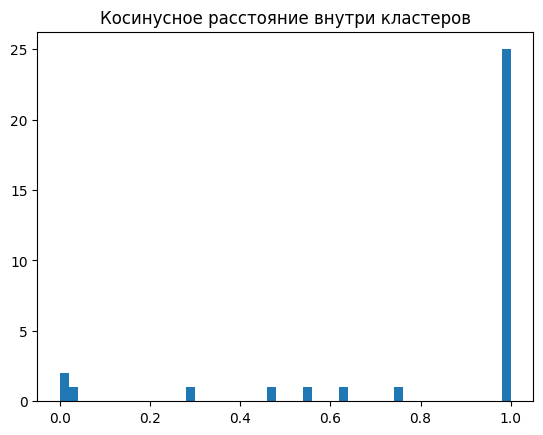

In [21]:
plt.hist(similarity_within_clusters, bins=50)
plt.title('Косинусное расстояние внутри кластеров')
plt.show()

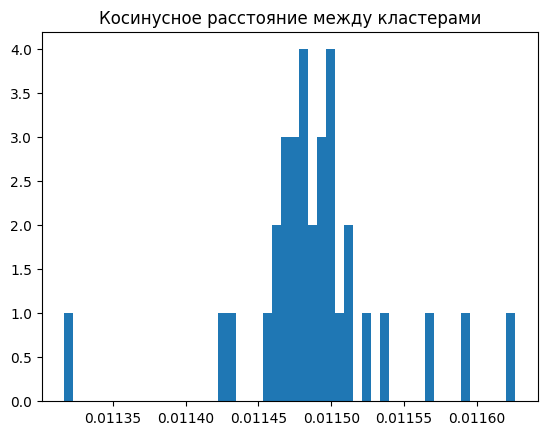

In [22]:
plt.hist(similarity_between_clusters, bins=50)
plt.title('Косинусное расстояние между кластерами')
plt.show()

# Сохраним фичи для всего трейна и рассчитаем Precision@k, Recall@k

In [23]:
# Общий список компаний

all_data = pd.concat([train_data, valid_data])
all_data['clean_name'] = all_data['name'].apply(clean_company_name_string)
all_data['clean_name_len'] = all_data['clean_name'].apply(len)
all_data.sort_values('clean_name_len', ascending=False, inplace=True)
all_data = all_data.reset_index()

# Список компаний из валидации
val_data = valid_data.copy()
val_data['clean_name'] = val_data['name'].apply(clean_company_name_string)
val_data['clean_name_len'] = val_data['clean_name'].apply(len)
val_data.sort_values('clean_name_len', ascending=False, inplace=True)
val_data = val_data.reset_index()

In [24]:
def get_embeddings(data, model):
    all_data_embds = []
    batch_size = 256
    for i in range(len(data) // batch_size + 1):
        batch = data['clean_name'].values[i * batch_size: (i + 1) * batch_size]
        with torch.no_grad():
            embds = model(batch).cpu()
        all_data_embds.append(embds)

    all_data_embds = torch.cat(all_data_embds)
    return all_data_embds

In [25]:
all_embds = get_embeddings(all_data, net)
print(all_embds.shape)

val_embds = get_embeddings(val_data, net)
print(val_embds.shape)

torch.Size([17872, 160])
torch.Size([1774, 160])


### Рассчитаем Precision для всех кластеров из валидации

In [29]:
K = 5

similarity = CosineSimilarity()
all_clusters_precision = []
cluster_ids = []

for cluster_id in tqdm.tqdm(val_data['cluster'].unique()):
    if cluster_id == -1:
        continue
    cluster = val_data[val_data['cluster'] == cluster_id]
    cluster_size = len(cluster)
    idxs = cluster.index.values
    cluster_embds = val_embds[idxs]
    cluster_precision = []
    for i in range(cluster_size):
        query_idx = cluster['index'].values[i]
        embds_with_query = torch.cat([all_embds, cluster_embds[i].unsqueeze(0)])
        similarity_scores = similarity(embds_with_query)[-1][:-1]

        prediction_df = all_data.copy()
        prediction_df['similarity'] = similarity_scores
        prediction_df = prediction_df.sort_values('similarity', ascending=False)
        prediction_df = prediction_df[prediction_df['index'] != query_idx].reset_index(drop=True)
        prediction_df = prediction_df.iloc[:K]
        cluster_preds = prediction_df['cluster'].values
        found = cluster_id in cluster_preds
        # Учитываем что в кластер входит и сам item, по которому делаем "поиск"
        cluster_precision.append(found)
    all_clusters_precision.append(np.mean(cluster_precision))
    cluster_ids.append(cluster_id)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:33<00:00,  1.00it/s]


In [30]:
print(f'Средний precision по кластерам (по скольки элементам из кластера есть совпадение в TOP 5: {np.mean(all_clusters_precision)}')

Средний precision по кластерам (по скольки элементам из кластера есть совпадение в TOP 5: 0.6048581048581049
